In [23]:
!pip install lyricsgenius
!pip install spotipy lyricsgenius

In [13]:
import os
import base64
import json
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import lyricsgenius
from requests import post, get
import pandas as pd
import os.path
import csv
import time
from bs4 import BeautifulSoup
from urllib.parse import quote
import requests
import re

# Setup Spotify
spotify_client_id = 'd484716d34b3490a910fc0e82a79e0b6'
spotify_client_secret = 'c5d36872bc10454e9c805c92797ec211'
spotify_credentials = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
spotify = spotipy.Spotify(client_credentials_manager=spotify_credentials)


##Setup Genius
client_access_token = 'BLKJ3IUN6tQ4rfdEGoxTN6XWtUA_yGT7t0UyhSYDImm3PKoIlDhitfSbUcQZoQ5c'
genius = lyricsgenius.Genius(client_access_token, remove_section_headers=True, skip_non_songs=True, timeout=15)

In [25]:
#Fetch songs from training playlist:
#https://open.spotify.com/playlist/1C8RuvGfRsX1fmxaehox9K?si=20f61f5fd4e34b92 
playlist_id = '1C8RuvGfRsX1fmxaehox9K'  
tracks = spotify.playlist_tracks(playlist_id)
track_list = tracks['items']
track_ids = [track['track']['id'] for track in track_list]
track_names = [track['track']['name'] for track in track_list]
track_artists = [track['track']['artists'][0]['name'] for track in track_list]
songs_df = pd.DataFrame({'track_id': track_ids, 'track_name': track_names, 'track_artist': track_artists})

#Fetch lyrics for each song
def get_lyrics(song_title, artist_name):
    song = genius.search_song(song_title, artist_name)
    if song:
        return song.lyrics
    else:
        return None
    
def clean_lyrics(lyrics):
    # Remove unwanted starting text up to "Lyrics"
    if "Lyrics" in lyrics:
        lyrics = lyrics.split("Lyrics")[1]
    # Remove any trailing content after the last repeated chorus or outro
    outro_index = lyrics.rfind("Outro")
    if outro_index != -1:
        lyrics = lyrics[:outro_index + len("Outro")]
    return lyrics.strip()

lyrics = []
for i, row in songs_df.iterrows():
    row['track_name'] = re.sub(r'\([^)]*\)', '', row['track_name'])

    #If there is a - or ( in song name, remove the part after that
    if '-' in row['track_name']:
        row['track_name'] = row['track_name'].split('-')[0]
    if '(' in row['track_name']:
        row['track_name'] = row['track_name'].split('(')[0]
    
    lyrics.append(clean_lyrics(get_lyrics(row['track_name'], row['track_artist'])))

songs_df['lyrics'] = lyrics
#print(songs_df.head())


songs_df.to_csv('song_lyrics.csv', index=False)

Searching for "Blinding Lights" by The Weeknd...
Done.
Searching for "Shape of You" by Ed Sheeran...
Done.
Searching for "Someone You Loved" by Lewis Capaldi...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "Starboy" by The Weeknd...
Done.
Searching for "One Dance" by Drake...
Done.
Searching for "STAY " by The Kid LAROI...
Done.
Searching for "Sweater Weather" by The Neighbourhood...
Done.
Searching for "Believer" by Imagine Dragons...
Done.
Searching for "Heat Waves" by Glass Animals...
Done.
Searching for "Dance Monkey" by Tones And I...
Done.
Searching for "Perfect" by Ed Sheeran...
Done.
Searching for "rockstar" by Post Malone...
Done.
Searching for "Say You Won't Let Go" by James Arthur...
Done.
Searching for "lovely " by Billie Eilish...
Done.
Searching for "Closer" by The Chainsmokers...
Done.
Searching for "Watermelon Sugar" by Harry Styles...
Done.
Searching for "Señorita" by Shawn Mendes...
Done.
Searching for "Something Just Like This" by The Chains

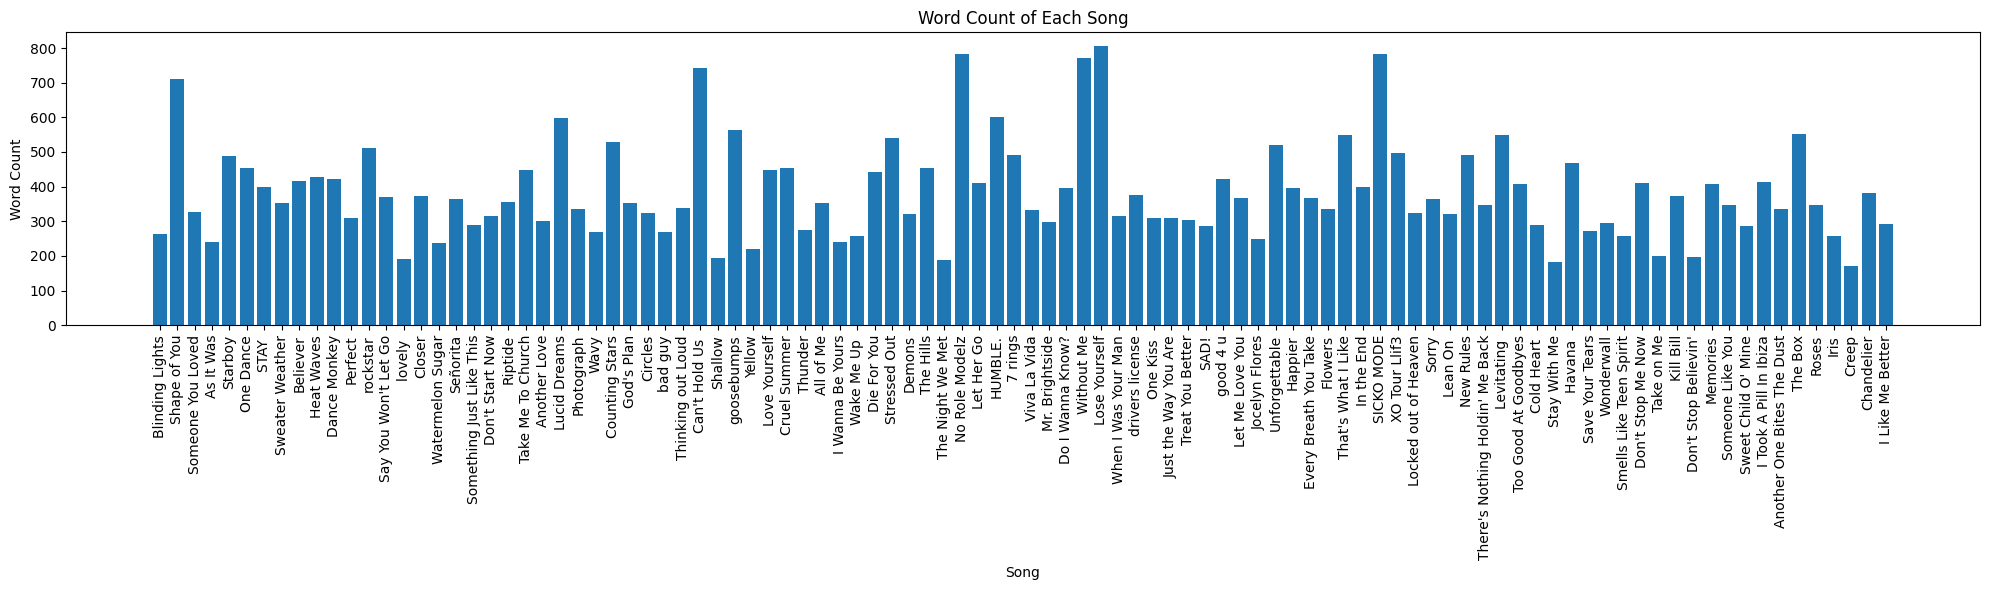

In [6]:
import matplotlib.pyplot as plt

#Read the lyrics from the csv file
songs_df = pd.read_csv('song_lyrics.csv')

#Plot the word count of each Song 
songs_df['word_count'] = songs_df['lyrics'].str.split().apply(len)
plt.figure(figsize=(20, 6))
plt.bar(songs_df['track_name'], songs_df['word_count'])
plt.xticks(rotation=90)
plt.xlabel('Song')
plt.ylabel('Word Count')
plt.title('Word Count of Each Song')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexapapandreou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexapapandreou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexapapandreou/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


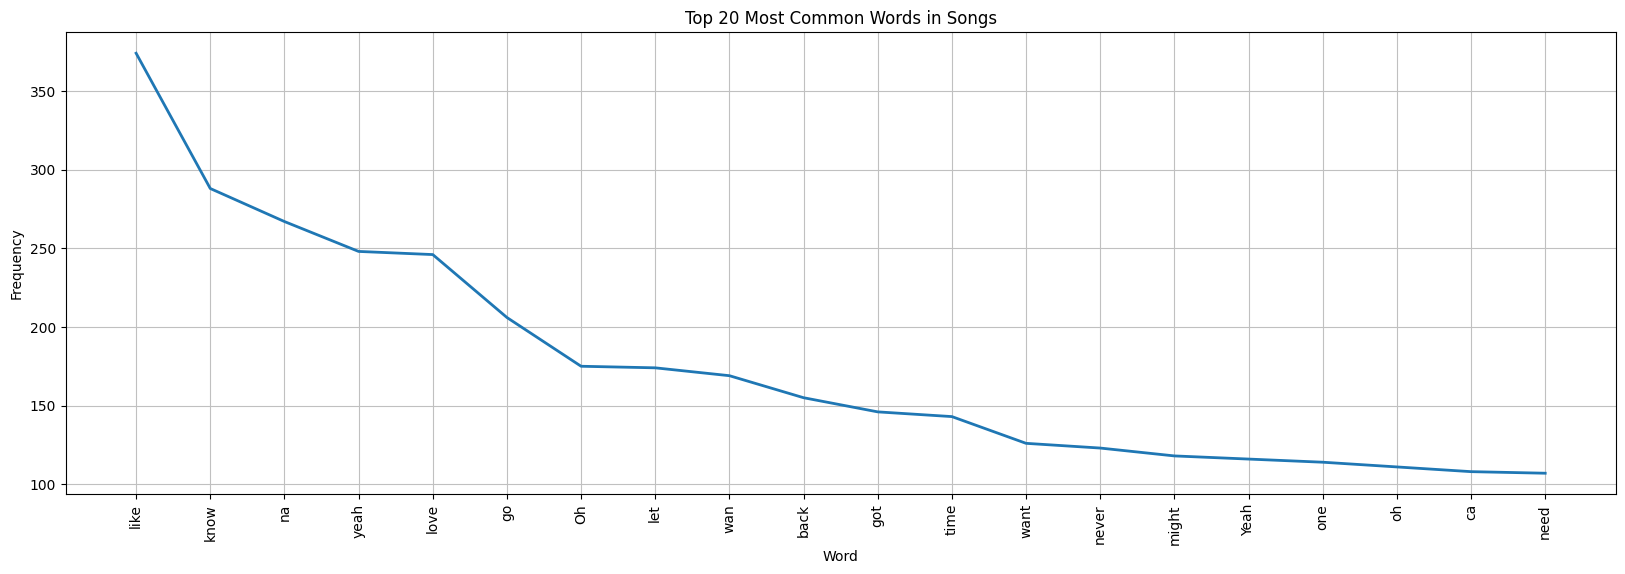

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string

# Download the punkt and stopwords from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Get the stop words and punkt from nltk
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

#Create a dictionary of songs and their lyrics
songs_dict = {}
for i, row in songs_df.iterrows():
    songs_dict[row['track_name']] = row['lyrics']

song_tokens = word_tokenize(''.join(songs_dict.values()))
filtered_songs = [w for w in song_tokens if not w.lower() in stop_words and not w in punctuation and w.isalpha()]
fdist_songs = FreqDist(filtered_songs)

#PLot the top 20 most common words
plt.figure(figsize=(20, 6))
fdist_songs.plot(20)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Songs')
plt.show()





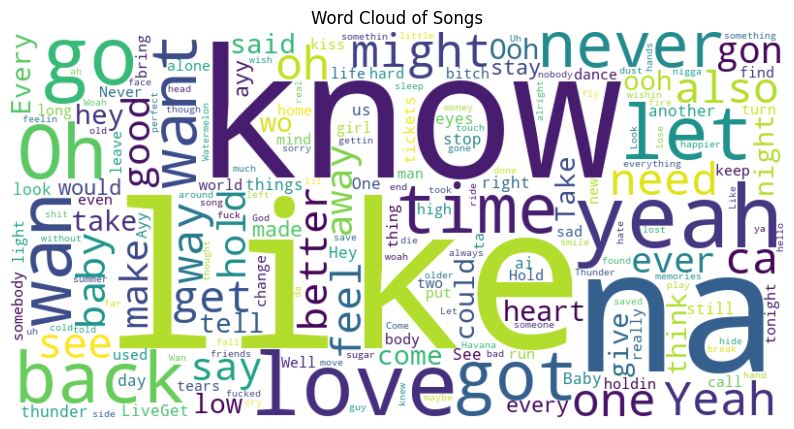

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(fdist_songs)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Songs')
plt.show()

In [19]:
!pip install gensim
!pip install textblob


           track_name  sentiment
0     Blinding Lights   0.032143
1        Shape of You   0.305706
2   Someone You Loved   0.229444
3           As It Was   0.053846
4             Starboy   0.131546
..                ...        ...
95              Roses  -0.052489
96               Iris  -0.151786
97              Creep   0.579286
98         Chandelier   0.177702
99   I Like Me Better   0.285758

[100 rows x 2 columns]


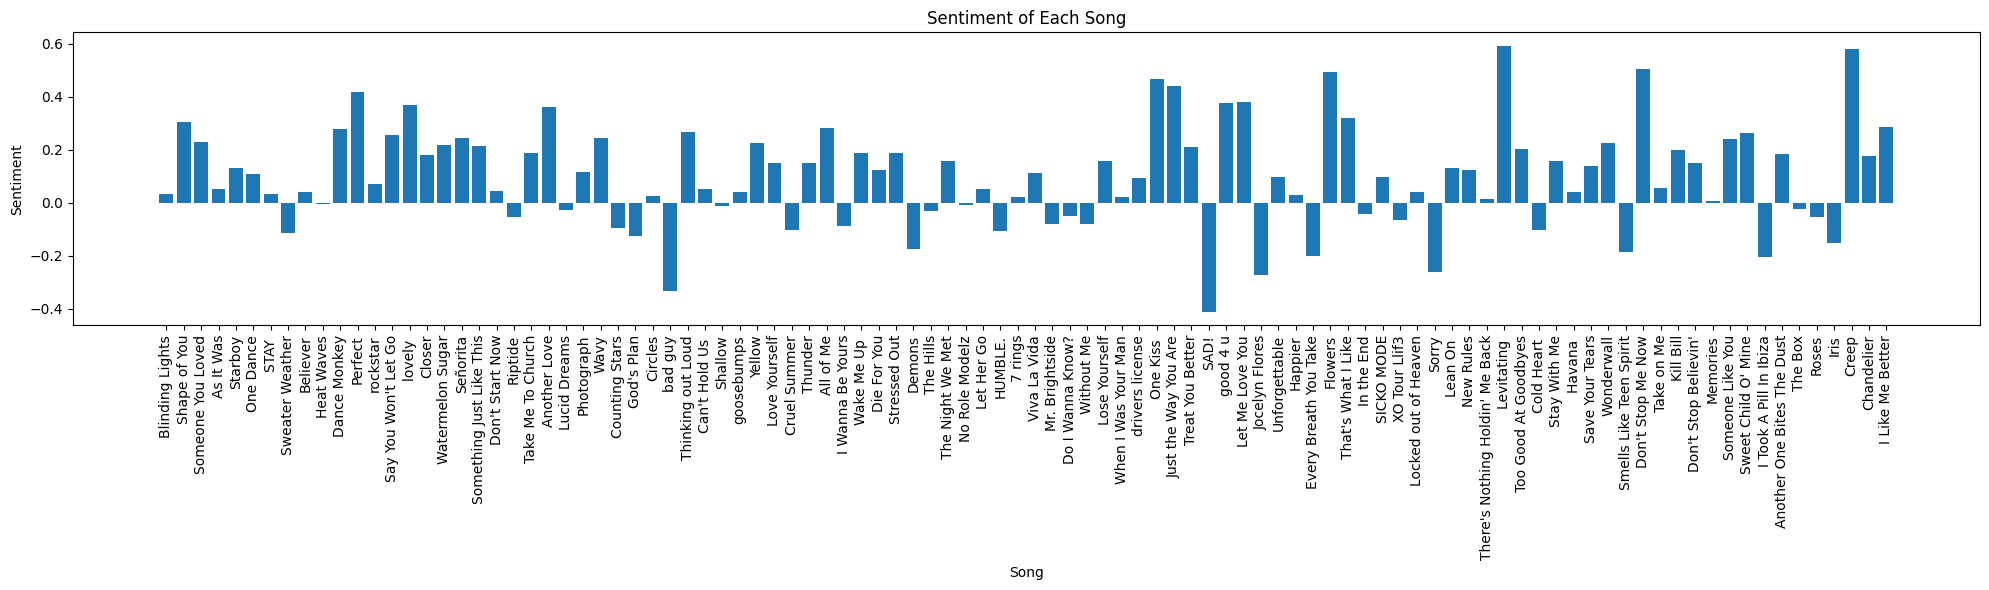

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

# Load your dataset
songs_df = pd.read_csv('song_lyrics.csv')

# Sentiment analysis (example using TextBlob)
from textblob import TextBlob
songs_df['sentiment'] = songs_df['lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)
#Show the sentiment of each song
print(songs_df[['track_name', 'sentiment']])
# Plot the sentiment of each song
plt.figure(figsize=(20, 6))
plt.bar(songs_df['track_name'], songs_df['sentiment'])
plt.xticks(rotation=90)
plt.xlabel('Song')
plt.ylabel('Sentiment')
plt.title('Sentiment of Each Song')
plt.tight_layout()
plt.show()




In [23]:

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(songs_df['lyrics'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

     132you   21   24  80s  82you  94you  aah  afford  afraid        ah  ...  \
0  0.000000  0.0  0.0  0.0    0.0    0.0  0.0     0.0     0.0  0.000000  ...   
1  0.025896  0.0  0.0  0.0    0.0    0.0  0.0     0.0     0.0  0.000000  ...   
2  0.000000  0.0  0.0  0.0    0.0    0.0  0.0     0.0     0.0  0.000000  ...   
3  0.000000  0.0  0.0  0.0    0.0    0.0  0.0     0.0     0.0  0.000000  ...   
4  0.000000  0.0  0.0  0.0    0.0    0.0  0.0     0.0     0.0  0.063977  ...   

        yah     yeah  years  yellow  yene  yep  yes   yo  young  물결치는  
0  0.000000  0.03328    0.0     0.0   0.0  0.0  0.0  0.0    0.0   0.0  
1  0.000000  0.00000    0.0     0.0   0.0  0.0  0.0  0.0    0.0   0.0  
2  0.000000  0.00000    0.0     0.0   0.0  0.0  0.0  0.0    0.0   0.0  
3  0.000000  0.00000    0.0     0.0   0.0  0.0  0.0  0.0    0.0   0.0  
4  0.006594  0.00000    0.0     0.0   0.0  0.0  0.0  0.0    0.0   0.0  

[5 rows x 1000 columns]


In [ ]:
# Word2Vec Model
words = [lyrics.split() for lyrics in songs_df['lyrics'].dropna()]
w2v_model = Word2Vec(sentences=words, vector_size=100, window=5, min_count=2, workers=4)
w2v_vectors = {word: w2v_model.wv[word] for word in w2v_model.wv.index_to_key}

# For each song, average the Word2Vec vectors of all words in the lyrics
def average_vectors(lyrics):
    vector = np.mean([w2v_vectors.get(word, np.zeros(100)) for word in lyrics.split()], axis=0)
    return vector

songs_df['lyrics_vector'] = songs_df['lyrics'].apply(average_vectors)

# Standardize audio features and concatenate with lyrics vector
scaler = StandardScaler()
audio_features = scaler.fit_transform(songs_df[['danceability', 'energy', 'valence', 'tempo']])
lyrics_vectors = np.array(songs_df['lyrics_vector'].tolist())

combined_features = np.concatenate([audio_features, lyrics_vectors], axis=1)

# Now combined_features can be used for further machine learning or image generation
